In [1]:
dataset_path = "../../data/raw/IMDB Dataset.csv"  # Replace with your IMDB dataset path
model_save_path = "xlnet_imdb_model.pth"  # Path to save the trained model

In [2]:
# Import dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.optim import AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from torch import half

In [3]:
# Load and prepare dataset
def load_imdb_data(path):
    # Modify this function based on your IMDB dataset format
    # Example if using CSV with 'review' and 'sentiment' columns
    df = pd.read_csv(path)
    df.columns = ['sentence', 'value']  # Standardizing column names
    return df

fd = load_imdb_data(dataset_path)

In [4]:
# Add special tokens
sentences = []
for sentence in fd['sentence']:
    sentence = str(sentence) + "[SEP] [CLS]"  # Ensure string type
    sentences.append(sentence)

In [5]:
# Tokenization
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

# Encode sentences
encoded = tokenizer(
    fd['sentence'].astype(str).tolist(),
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

In [6]:
# Pad sequences
input_ids = encoded['input_ids']
label_mapping = {'negative': 0, 'positive': 1}
fd['label'] = fd['value'].map(label_mapping)

# Now convert to PyTorch tensor
labels = torch.tensor(fd['label'].values.astype('int64'))

In [7]:
# Determine max length
MAX_LEN = 256
print(f"Maximum sequence length: {MAX_LEN}")

Maximum sequence length: 256


In [8]:
# Train-test split
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(input_ids, labels, test_size=0.15, random_state=42)

In [9]:
# After loading the dataset and before converting to tensors
# Convert string labels to numerical values (0 and 1)
if isinstance(fd['value'].iloc[0], str):
    fd['value'] = fd['value'].map({'positive': 1, 'negative': 0})  # Adjust based on your label names
    
# Then proceed with the rest of the code
labels = fd['value'].values.astype('int64')  # Ensure labels are integers

# Train-test split
xtrain, xtest, ytrain, ytest = train_test_split(input_ids, labels, test_size=0.15, random_state=42)
ytrain = torch.tensor(ytrain, dtype=torch.long)
# Convert to tensors - now this will work
Xtrain = torch.tensor(xtrain)
Ytrain = torch.tensor(ytrain)
Xtest = torch.tensor(xtest)
Ytest = torch.tensor(ytest)

C:\Users\adity\AppData\Local\Temp\ipykernel_10000\2685311311.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtrain = torch.tensor(xtrain)
C:\Users\adity\AppData\Local\Temp\ipykernel_10000\2685311311.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ytrain = torch.tensor(ytrain)
C:\Users\adity\AppData\Local\Temp\ipykernel_10000\2685311311.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtest = torch.tensor(xtest)


In [10]:
# Reduce batch size to avoid CUDA out-of-memory error
batch_size = 2 

# Convert ytest to a PyTorch tensor
ytest = torch.tensor(ytest, dtype=torch.long)

# Create TensorDatasets
train_data = TensorDataset(xtrain, ytrain)
test_data = TensorDataset(xtest, ytest)
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [11]:
# Model setup
from transformers import XLNetForSequenceClassification

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

model = model.to(device)

cuda


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Training configuration
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
epochs = 3

In [13]:
# Accuracy function
def flat_accuracy(preds, labels):
    correct = sum(1 for p, l in zip(preds, labels) if p == l)
    return (correct / len(labels)) * 100

In [14]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], 'b-o', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], 'r-o', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.draw()
    plt.pause(0.1)  # Allow dynamic updating



Epoch 1/3


Training Loss: 0.2671, Accuracy: 89.45%
Epoch Time: 8257.05s


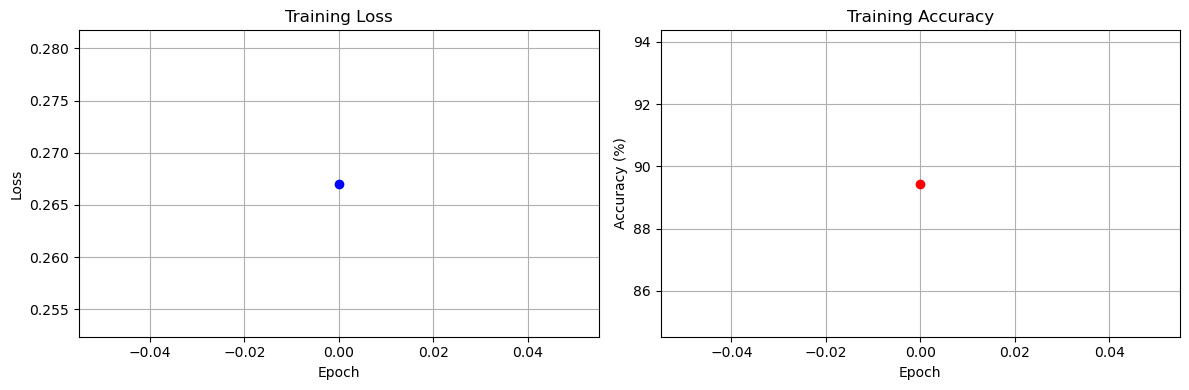


Epoch 2/3


Training Loss: 0.1936, Accuracy: 92.73%
Epoch Time: 6587.52s


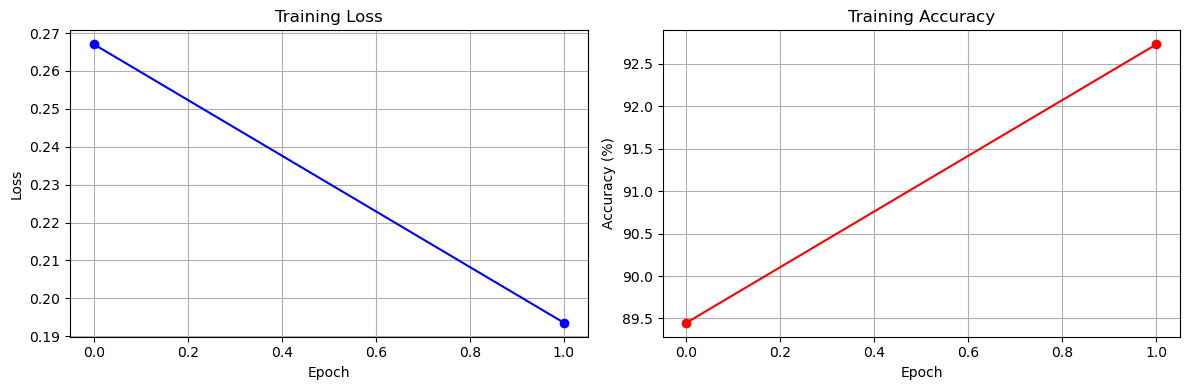


Epoch 3/3


Training Loss: 0.1530, Accuracy: 94.42%
Epoch Time: 6813.50s


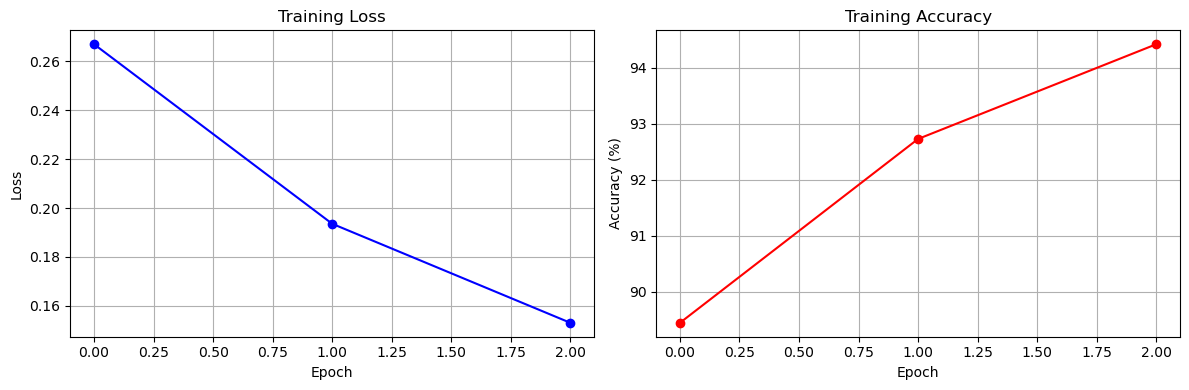

In [15]:
# Initialize training history
train_history = {
    'loss': [],
    'accuracy': [],
    'epoch_time': []
}

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    print(f"\nEpoch {epoch+1}/{epochs}")
    start_time = time.time()

    # Wrap the train_loader with tqdm for progress bar
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    end_time = time.time()
    avg_loss = total_loss / len(train_loader)
    accuracy = flat_accuracy(all_preds, all_labels)
    epoch_duration = end_time - start_time

    # Store metrics
    train_history['loss'].append(avg_loss)
    train_history['accuracy'].append(accuracy)
    train_history['epoch_time'].append(epoch_duration)

    # Print epoch summary
    print(f"Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Epoch Time: {epoch_duration:.2f}s")

    # Plot training history after each epoch
    plot_training_history(train_history)

# Final plot
plt.show()

In [16]:
# Evaluation
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs[0], dim=1).flatten()
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = flat_accuracy(test_preds, test_labels)
print(f"\nTest Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 92.27%


In [17]:
# Save model
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to xlnet_imdb_model.pth


In [18]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': loss,
    # Add other metadata (e.g., hyperparameters)
}
torch.save(checkpoint, model_save_path)

In [19]:

model.half()  # Convert model to FP16
torch.save(model.state_dict(), model_save_path)